## BAYESIAN BANDITS
bodapa@gmail.com

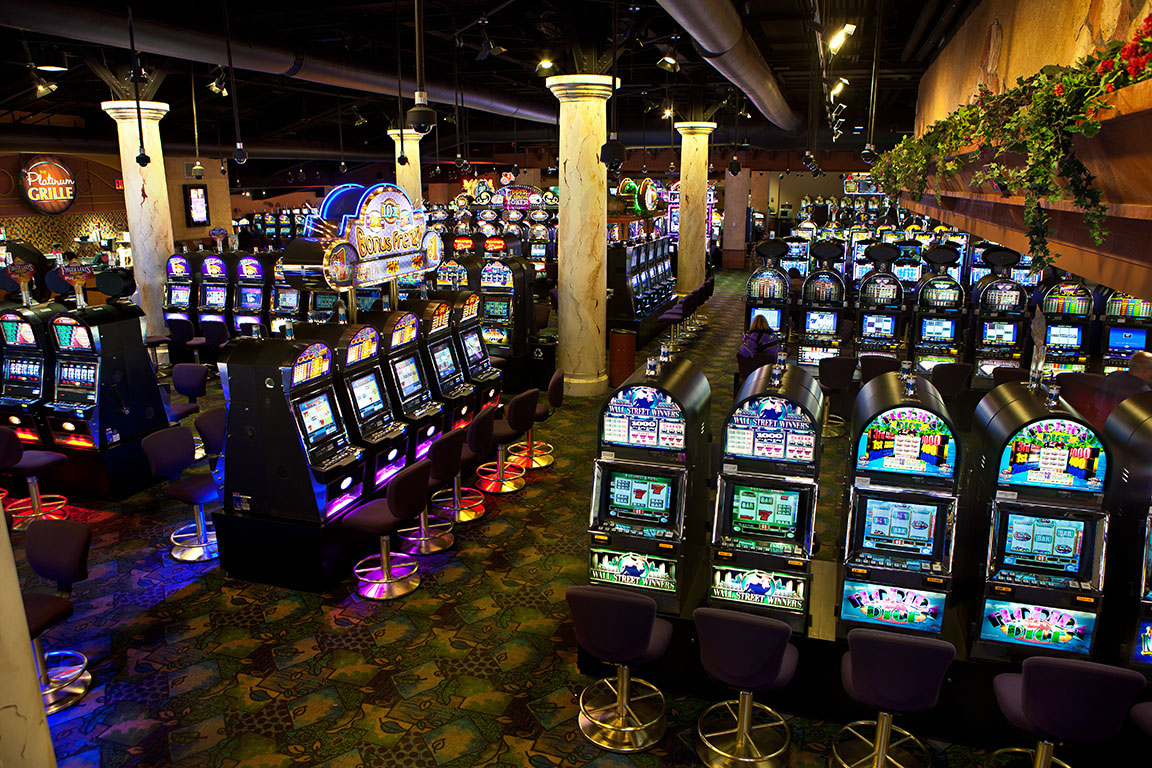

In [2]:
from IPython.display import Image
Image("Slots.jpg")

In [3]:
import pyGPs
import numpy as np
from scipy import stats
import pandas as pd
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.gridspec as gs

# construct a truth to be validated
def func1(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

### Problem Statement

Number of bandits: N (discrete or continuous)

Goal: Minimize Regret

Central Dilemma: Explore vs. Exploit

The problem here is one of learning through the environment. As an agent interacts with the environment through action(s), learning is desired about a certain problem.

### Applications

1. Ad display

2. Robotic gait

3. Portfolio optimization

4. Any reinforcement learning problem: learning NN hyperparameters instead of an expensive grid search

5. Geosciences: Mining / Exploration Models

6. Any experimental design where each experiment is expensive


### Bayesian Solution

Bayes Rule:

$$ posterior = \frac{likelihood \times prior}{marginal} $$

$$ p(\theta|D) = \frac{p(D|\theta) \times p(\theta)}{p(D)} $$

Key Steps:

1. Assume a prior distribution 

2. Obtain data

3. Estimate posterior

4. Update prior based on the posterior 

and, repeat until the optimal value(s) is found


### Beta Bernoulli Basics

In the present report, 4 Bandits are considered to help elucidate the concepts. The key in this model is that the bandits are assumed to be independent of each other. Further we assume that each has a Beta prior with the conjugate Bernoulli determining the output.

Each Bandit is assumed to be an independent Bernoulli random variable:

$$ X_1, X_2, ..., X_N \sim Bern(\theta) $$

Prior:
$$ \theta \sim Beta(\alpha, \beta) $$

Posterior:
$$ p(\theta | D) = Beta(\alpha + n_1, \beta+n_0) $$

Hyper-Parameters: $\alpha$ and $\beta$

Pseudo-Counts: $n_1$ and $n_0$

Posterior Mean:
$$ E(\theta|D) = \frac{\alpha + n_1}{\alpha + \beta + n} $$

Posterior MLE (Empirical Probability Estimate):
$$ \theta_{MLE} = \frac{n_1}{n} $$

### Thompson Sampling Algorithm

Initialization:$ \alpha = \beta = 1 $. In other words, we assume an initial uniform prior on each of the bandits.


for each $t = 1,2,... $ do

for each arm $i = 1, ..., N $ 

sample $\theta_i(t)$ from the $Beta(\alpha, \beta)$ distribution.

Play $arm_i(t) := argmax_i \theta_i(t)$ and observe reward $\sim r_t$.

Perform a Bernoulli trial with success probability $\sim r_t$ and observe output $r_t$
    
If $r_t = 1$ then 
        $\alpha_i = \alpha_i + 1$ 
    else 
        $\beta_i = \beta_i + 1$

end

In [4]:
def betabernoulli(n_trials):
        # initialization of regret
        regret = []
        # say there are 4 bandits
        n_arms = 4
        # all the priors are beta distributions (uniform)
        alpha = np.array([1,1,1,1])
        beta = np.array([1,1,1,1])
        
        # each of the following 4 probabilities are the unknown
        prob_bern = [0.1,0.35,0.65,0.85]
        
        # begin thompson sampling
        for i in np.arange(n_trials):
            #print i, "ntrials"
            theta = []
            for j in np.arange(n_arms):
                #print j, "narms"
                theta.append(stats.beta.rvs(alpha[j], beta[j], size=1))
                theta1 = np.array(theta)
                #print theta1
                
                # find the maximum theta and the arm with max theta
                max_arm = theta1.argmax()
                max_theta = np.max(theta1)
                #print max_arm, max_theta
                
                # play the arm with max theta
                r_t = stats.bernoulli.rvs(p=prob_bern[max_arm], size=1 )
                if r_t == 1:
                    alpha[max_arm] = alpha[max_arm] + 1
                else:
                    beta[max_arm] = beta[max_arm] + 1
                
                # regret formulation
                reg = []
                for k in np.arange(n_arms):
                    reg.append(np.divide(alpha[k] , (alpha[k] + beta[k]), dtype=float))
                #
            
            regret.append(np.sum(reg[max_arm] - reg))
                #
        return regret, alpha, beta
    

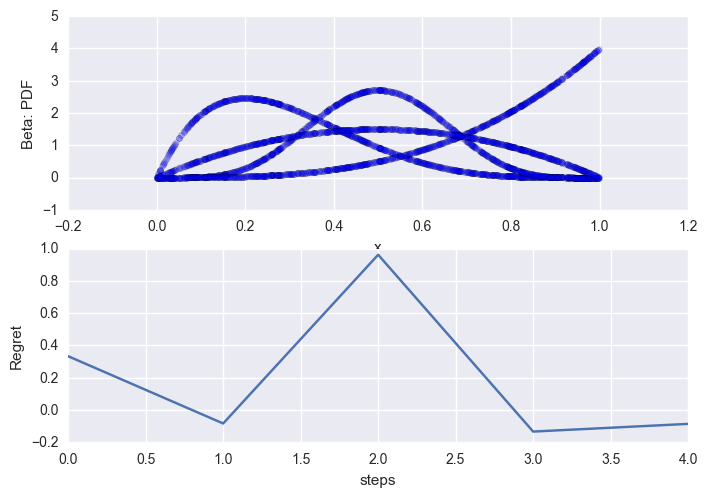

In [15]:
'''
SIMULATE FOUR (4) BERNOULLI BANDITS WITH PROBABILITIES: [0.1,0.35,0.65,0.85]
'''

# number of trials
trials = 5
n_arms = 4
regret, alpha, beta = betabernoulli(n_trials = trials)

g1 = gs.GridSpec(2,1)
x = np.random.rand(1000)

ax1 = plt.subplot(g1[0,0])
for i in np.arange(n_arms):
    plt.scatter(x, stats.beta(alpha[i], beta[i]).pdf(x),alpha=0.15)
plt.xlabel('x')
plt.ylabel('Beta: PDF')

ax2 = plt.subplot(g1[1,0])
plt.plot((regret))
plt.xlabel('steps')
plt.ylabel('Regret')
plt.title(' ')


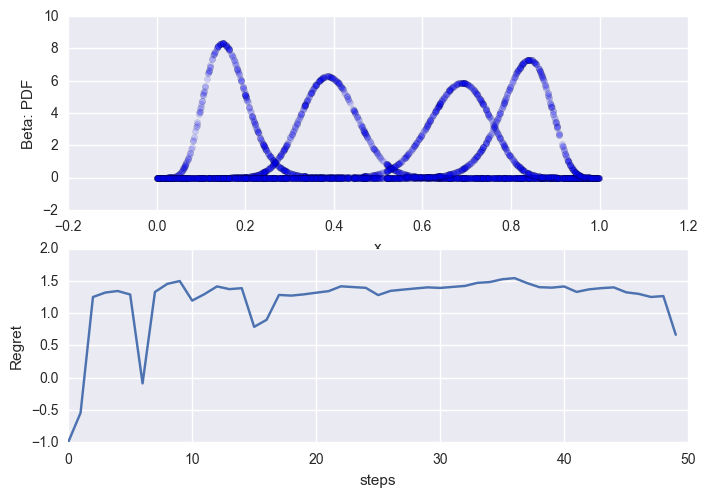

In [16]:
# number of trials
trials = 50
n_arms = 4
regret, alpha, beta = betabernoulli(n_trials = trials)

g1 = gs.GridSpec(2,1)
x = np.random.rand(1000)

ax1 = plt.subplot(g1[0,0])
for i in np.arange(n_arms):
    plt.scatter(x, stats.beta(alpha[i], beta[i]).pdf(x),alpha=0.15)
plt.xlabel('x')
plt.ylabel('Beta: PDF')

ax2 = plt.subplot(g1[1,0])
plt.plot((regret))
plt.xlabel('steps')
plt.ylabel('Regret')
plt.title(' ')


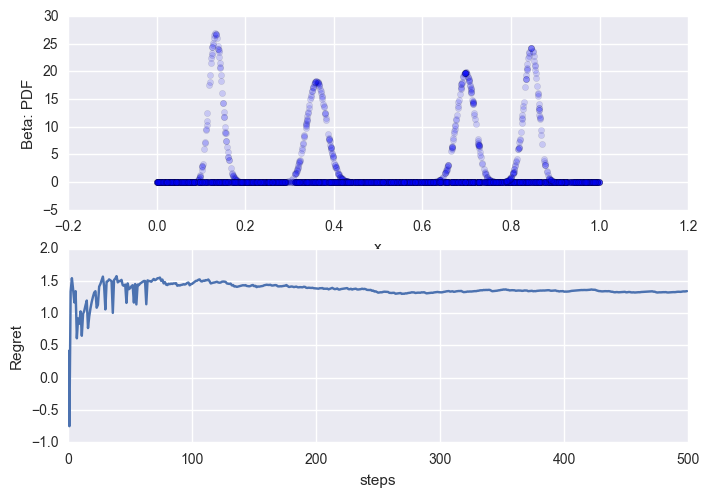

In [17]:
# number of trials
trials = 500
n_arms = 4
regret, alpha, beta = betabernoulli(n_trials = trials)

g1 = gs.GridSpec(2,1)
x = np.random.rand(1000)

ax1 = plt.subplot(g1[0,0])
for i in np.arange(n_arms):
    plt.scatter(x, stats.beta(alpha[i], beta[i]).pdf(x),alpha=0.15)
plt.xlabel('x')
plt.ylabel('Beta: PDF')

ax2 = plt.subplot(g1[1,0])
plt.plot((regret))
plt.xlabel('steps')
plt.ylabel('Regret')
plt.title(' ')

In [8]:
xmin = -15
xmax = 20
x1 = np.linspace(xmin,xmax,1000)
y1 = func1(x1)

# training dataset
n = 3 # initial sunk cost
m = 1000

#x_init = np.linspace(xmin,xmax,n)
x_init = np.sort(np.random.uniform(xmin, xmax, n))


## Bayesian Optimization with Gaussian Process Prior


### Gaussian Processes
A gaussian process is a collection of random variables, any finite number of which have a joint Gaussian distribution.

$$ y = f(x) + \epsilon $$

$$ \epsilon \sim N(0, \sigma_y^2) $$

$$ f(x) \sim GP(m(x), \kappa(x, x')) $$

where,
$$ m(x) = E[f(x)]  = 0 (assumed) $$
$$ \kappa(x,x') = E[(f(x) - m(x))(f(x') - m(x')] $$

Various Kernels can be used. Most popular is RBF (Squared Exponential Kernel)
$$ \kappa(x,x') = exp(-\frac{1}{2} (x - x')^T diag(\theta)^{-2} (x - x')) $$

Hyper-Parameters: $\theta$ 

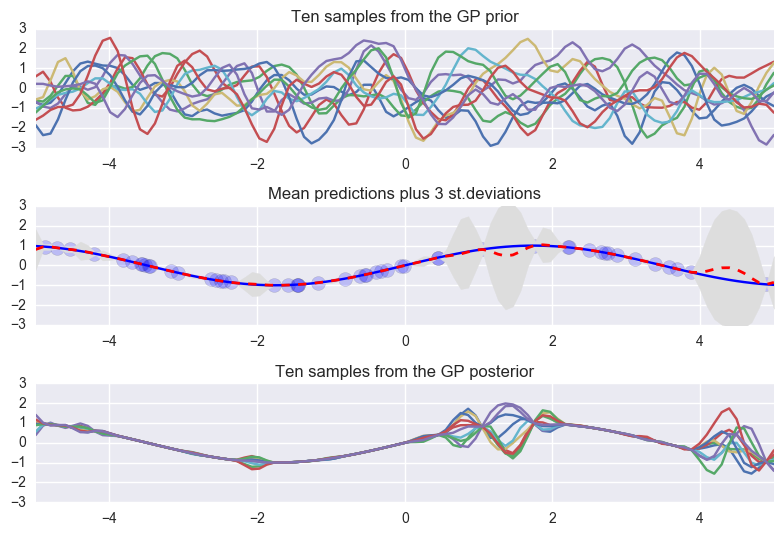

In [9]:
'''
GAUSSIAN PROCESS REGRESSION 
'''

# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()
#f = lambda x: (0.25*(x**2)).flatten()


# Define the kernel
def kernel(a, b):
    """ GP squared exponential kernel """
    kernelParameter = 0.05
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/kernelParameter) * sqdist)

N = 50         # number of training points.
n = 100         # number of test points.
s = 0.0000    # noise variance.

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X = np.random.uniform(-5, 5, size=(N,1))
y = f(X) + s*np.random.randn(N)

K = kernel(X, X)
L = np.linalg.cholesky(K + s*np.eye(N))

# points we're going to make predictions at.
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, y))
#print mu
# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
s = np.sqrt(s2)

# PLOTS:
g1 = gs.GridSpec(3,1)

# draw samples from the prior at our test points.
ax1 = plt.subplot(g1[0,0])
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n,10)))
plt.plot(Xtest, f_prior)
plt.title('Ten samples from the GP prior')
plt.axis([-5, 5, -3, 3])

# posterior predictions
ax2 = plt.subplot(g1[1,0])
plt.plot(X, y, 'r+', ms=20)
plt.scatter(X,y, s=100, alpha=0.2)
plt.plot(Xtest, f(Xtest), 'b-')
plt.gca().fill_between(Xtest.flat, mu-3*s, mu+3*s, color="#dddddd")
plt.plot(Xtest, mu, 'r--', lw=2)
plt.title('Mean predictions plus 3 st.deviations')
plt.axis([-5, 5, -3, 3])


# draw samples from the posterior at our test points.
ax3 = plt.subplot(g1[2,0])
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,10)))
plt.plot(Xtest, f_post)
plt.title('Ten samples from the GP posterior')
plt.axis([-5, 5, -3, 3])

plt.tight_layout()


### Bayesian Optimization via GP

Key Points:

1. Non-convex optimization problems can be handled quite easily with GPs.

2. The response surface (function) is extremely expensive to learn and we don't have a good prior knowledge about it. Loosely speaking, our prior is fuzzy.

3. Beta Bernoulli works well with discrete or continuous random variables which are independent. GPs are a more general approach that is not restricited by independence.

4. GPs do assume that similar inputs lead to similar outputs. This is a key assumption of the model which could pose issues when dealing with problems such as image and voice. 

5. Been a late bloomer and lately been very successfully used for NNets hyperparameters, robotic gait, sensor placement, intelligent user design etc...


Algorithm:

1. Assume a GP prior with a zero mean and a kernel (squared exponential in the present case)

2. Sunk cost: Get a (few) response(s) $(x_i, y_i)$ to initiate

3. Estimate the posterior mean, variance across the range of interest

4. Utitlity Function: Also called acquisition function, is used to guide the decision to pick the next value of $x_{t+1}$. We have variants of the utility functions: probability of improvement, expected improvement, UCB (upper confidence bound) etc... We will use PI and EI in this present demo.

5. Estimate the regret





In [10]:
xmin = -15
xmax = 20
x1 = np.linspace(xmin,xmax,1000)
y1 = func1(x1)

# training dataset
n = 3 # initial sunk cost
m = 1000

x_init = np.linspace(xmin,xmax,n)
#x_init = np.sort(np.random.uniform(xmin, xmax, n))


In [11]:
def bayOpt(x_train, chi):
        #
        #################################
        y_train = func1(x_train)
        x_test = np.linspace(xmin,xmax,m)
        
        model = pyGPs.GPR()                         # specify model (GP regression)
        model.getPosterior(x_train, y_train)                  # fit default model (mean zero & rbf kernel) with data
        model.optimize(x_train, y_train, numIterations=500)   # optimize hyperparamters (default optimizer: single run minimize)
        ymu, ys2, fmu, fs2, lp = model.predict(x_test)  # predict test cases
        
        # utility functions    
        #chi = .5
        mumax = np.max(ymu)
        #print mumax
        #print len(ymu), len(ys2)
        pi_opt = list()
        ei_opt = list()
        for i in np.arange(len(ymu)):
            d = (ymu[i] - mumax - chi)
            pi_optvar = d / (np.sqrt(ys2[i]))
            if np.sqrt(ys2[i]) > 0.1:
                #print np.sqrt(ys2[i])
                ei_optvar = d*stats.norm.cdf(pi_optvar) + np.sqrt(ys2[i])*stats.norm.pdf(pi_optvar)
            else:
                ei_optvar = 0
            pi_opt.append(stats.norm.cdf(pi_optvar))
            ei_opt.append(ei_optvar)
        #print np.max(ei_opt), z1[ei_opt.index(np.max(ei_opt))], ei_opt.index(np.max(ei_opt))
        
        # plots
        xss  = np.reshape(x_test,(x_test.shape[0],))
        ymm  = np.reshape(ymu,(ymu.shape[0],))
        ys22 = np.reshape(ys2,(ys2.shape[0],))    
        g1 = gs.GridSpec(3,1)
        
        ax1 = plt.subplot(g1[0,0])
        plt.plot(x1, y1, label = 'truth') 
        plt.scatter(x_train, y_train, s=150, alpha=0.85, label='training', color='red', marker = 'v')
        plt.plot(x_test, ymu, 'r--', label = 'posterior mean')
        plt.fill_between(xss,ymm + 2.*np.sqrt(ys22), ymm - 2.*np.sqrt(ys22), facecolor='grey', linewidths=0.0, alpha=0.25, label = 'posterior variance')
        plt.xlim(-20,25)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        ax2 = plt.subplot(g1[1,0])
        plt.plot(x_test, pi_opt, label = '$\zeta$ = %s'%(chi))
        plt.axvline(x_test[pi_opt.index(np.max(pi_opt))], color='g')
        plt.xlim(-20,25)
        plt.yticks([])
        plt.xlabel('$x$')
        plt.ylabel('PI(x)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        ax3 = plt.subplot(g1[2,0])
        plt.plot(x_test, ei_opt, label = '$\zeta$ = %s'%(chi))
        plt.axvline(x_test[ei_opt.index(np.max(ei_opt))], color='r')
        plt.xlim(-20,25)
        plt.yticks([])
        plt.xlabel('$x$')
        plt.ylabel('EI(x)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        #print 'x train'
        #print x_train
        x_train = np.append(x_train, x_test[ei_opt.index(np.max(ei_opt))])
        #print x_train
        # regret function
        f_max = np.max(y_train)
        f_xt = func1(  x_test[ei_opt.index(np.max(ei_opt))] )
        regrt.append(f_max - f_xt)
        #print 'Regret = ', regrt
        
        return x_train, regrt
    ################################



time step: 1
Number of line searches 5


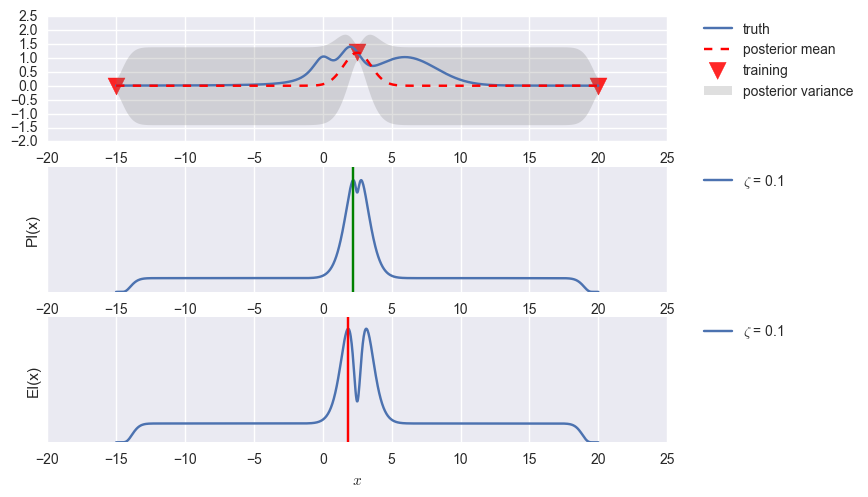


time step: 2
Number of line searches 56


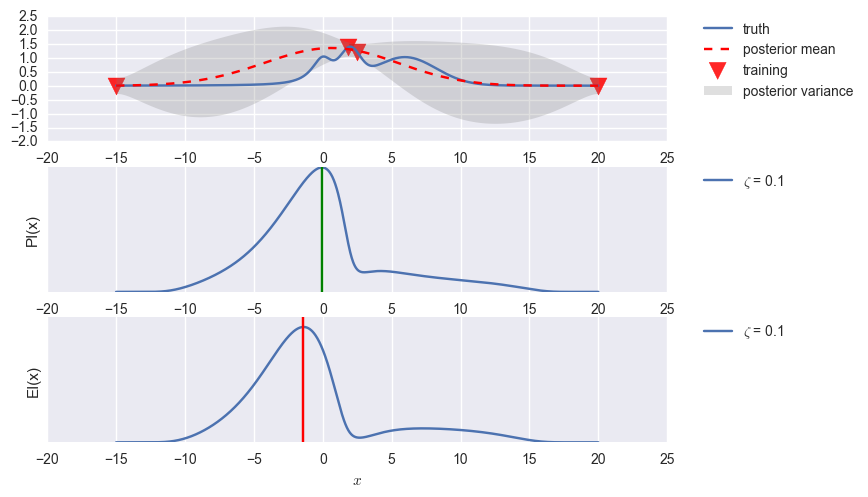


time step: 3
Number of line searches 500


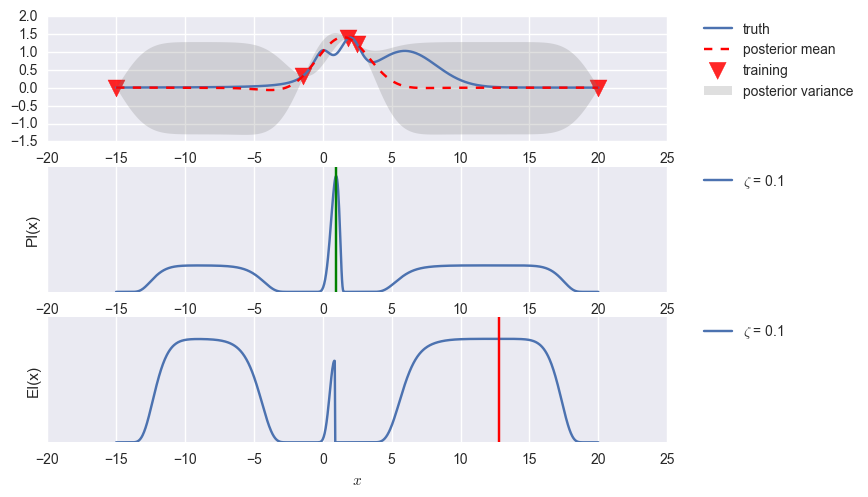


time step: 4
Number of line searches 500


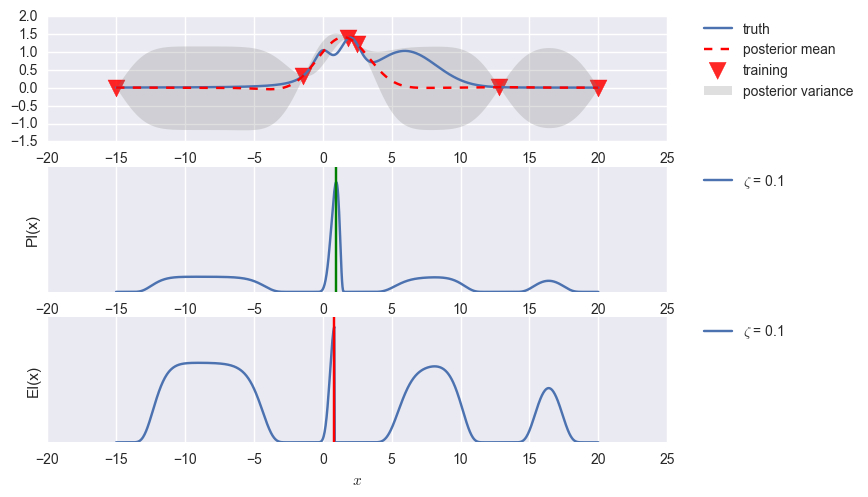


time step: 5
Number of line searches 500


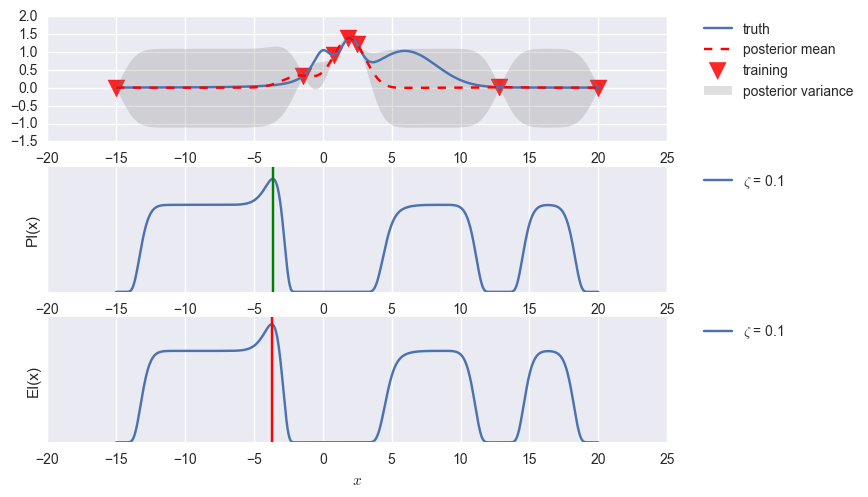


time step: 6
Number of line searches 21


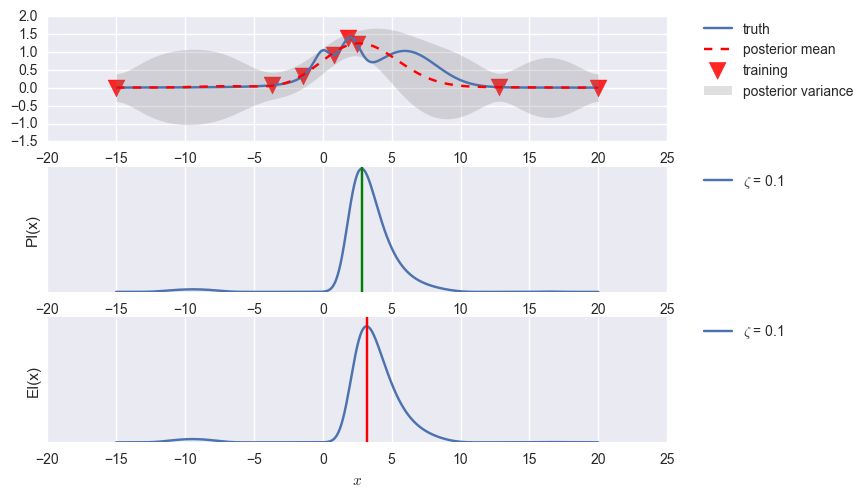


time step: 7
Number of line searches 500


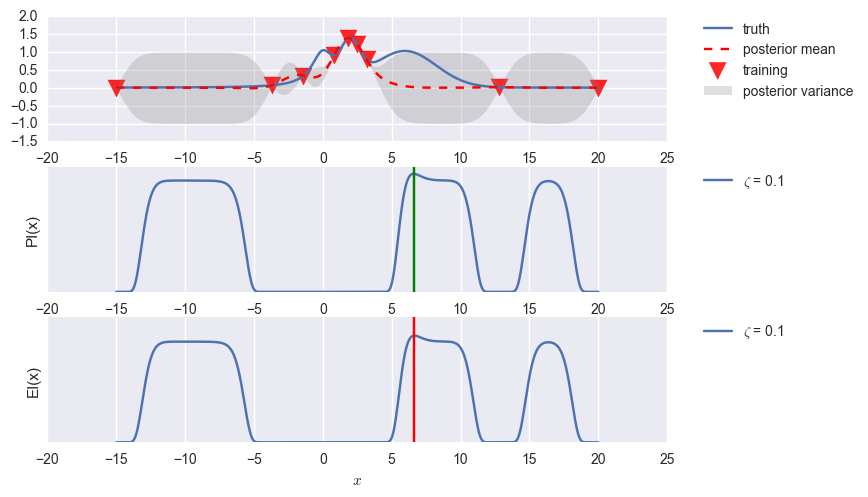


time step: 8
Number of line searches 500


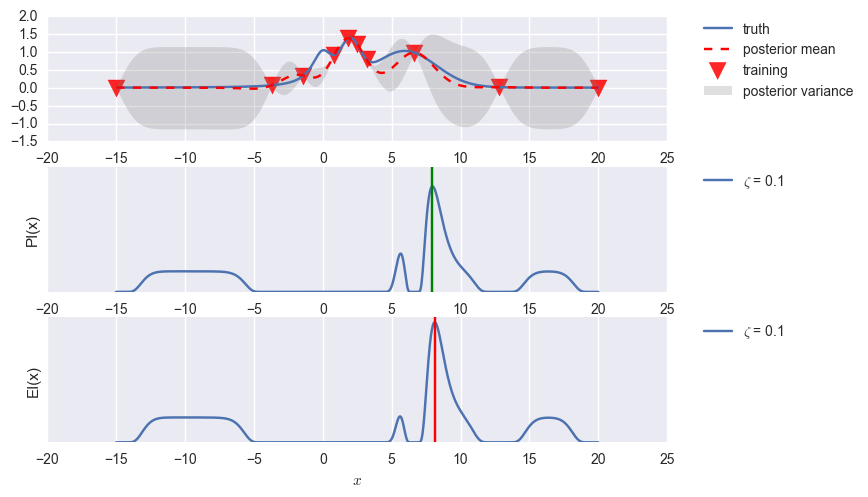


time step: 9
Number of line searches 270


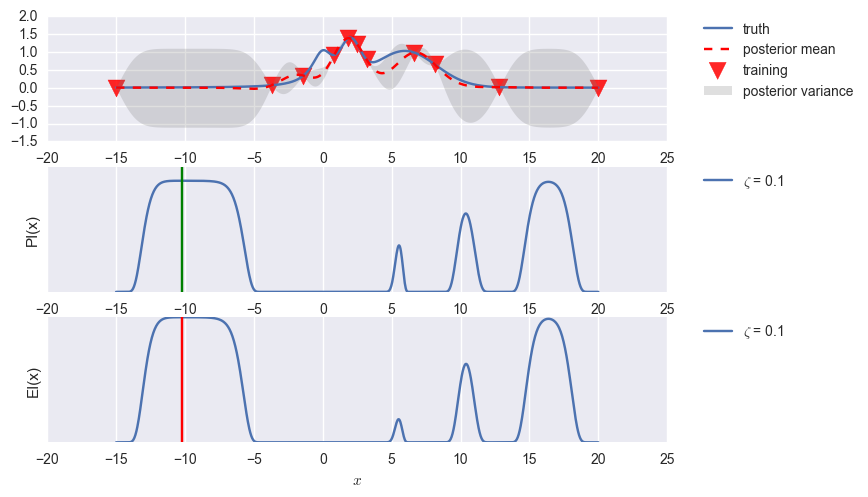


time step: 10
Number of line searches 500


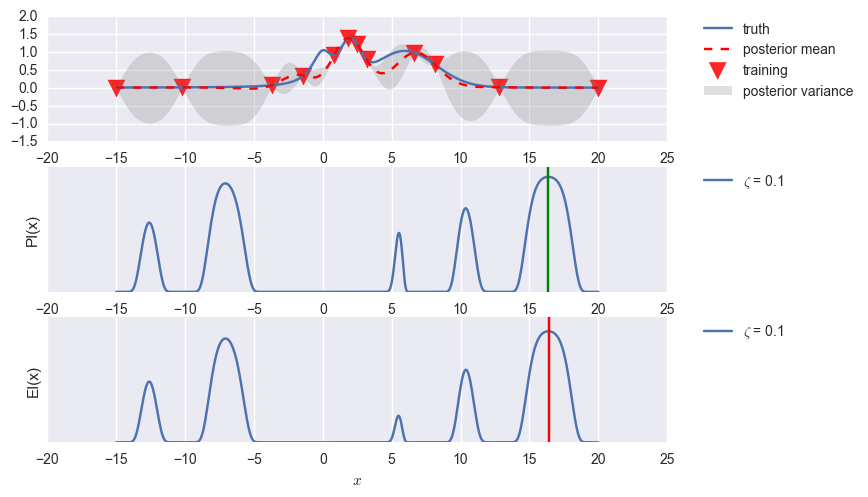


time step: 11
Number of line searches 500


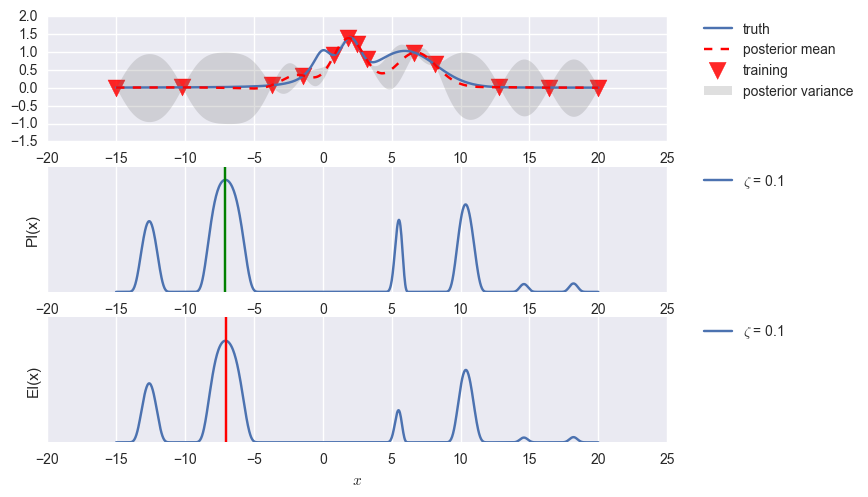


time step: 12
Number of line searches 500


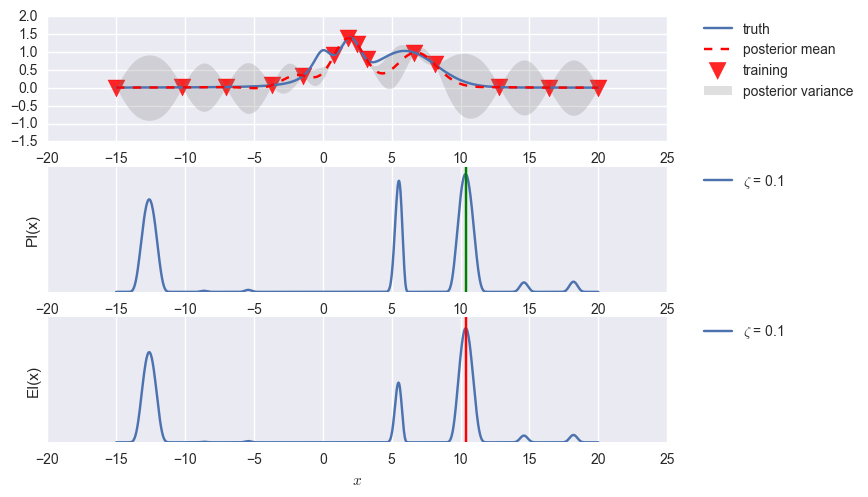


time step: 13
Number of line searches 500


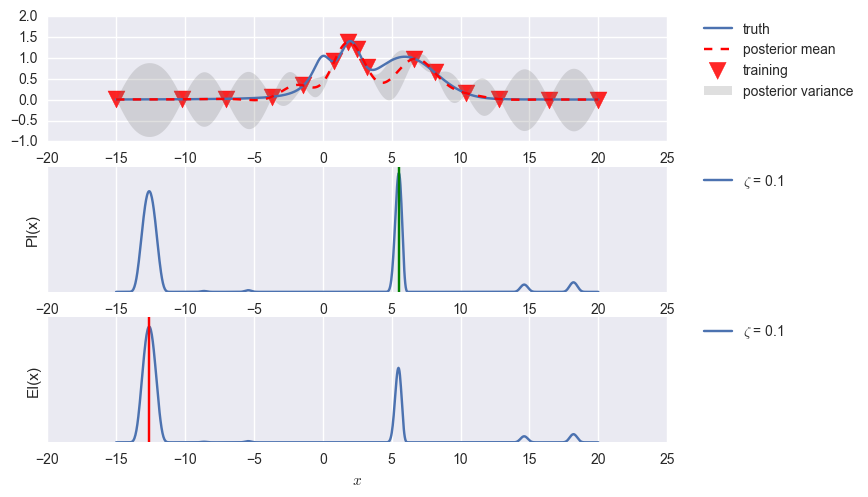


time step: 14
Number of line searches 500


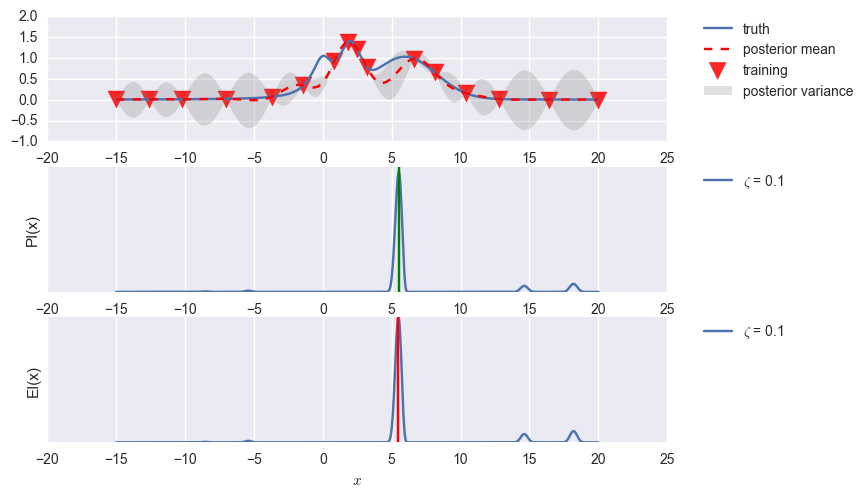


time step: 15
Number of line searches 500


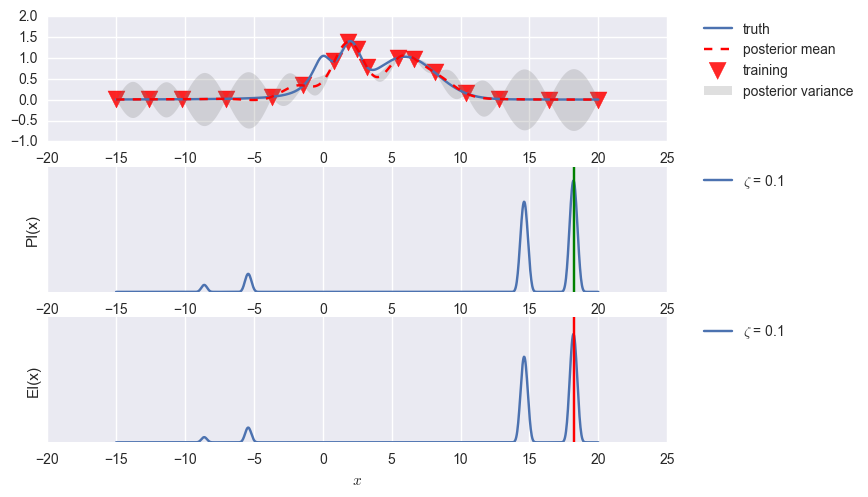


time step: 16
Number of line searches 440


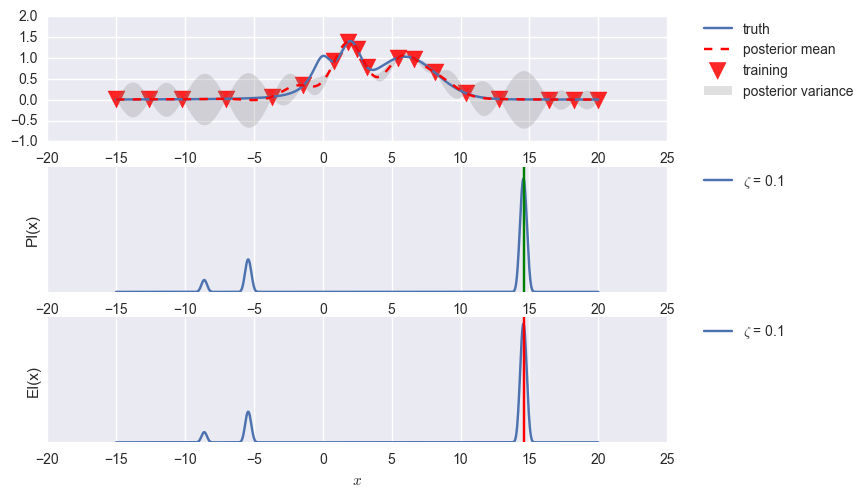


time step: 17
Number of line searches 20


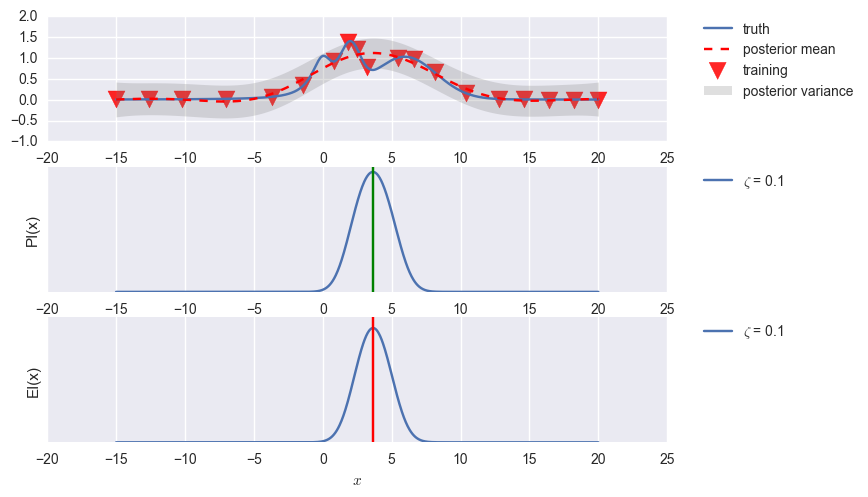


time step: 18
Number of line searches 27


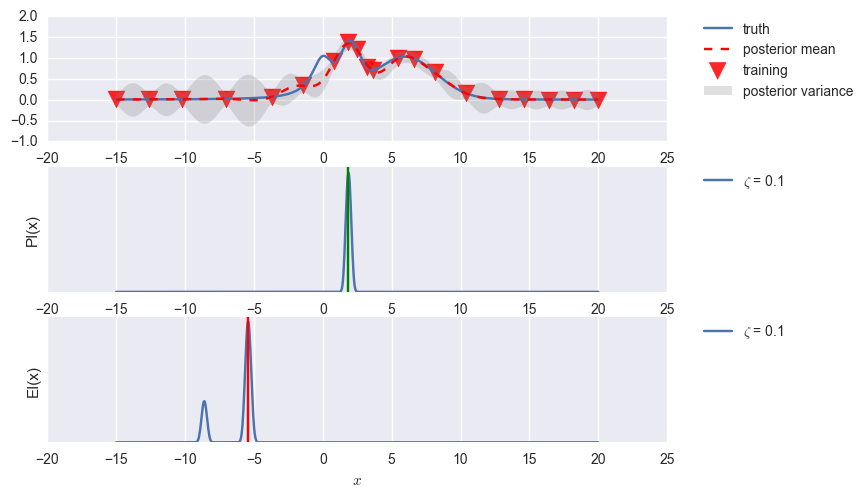


time step: 19
Number of line searches 41


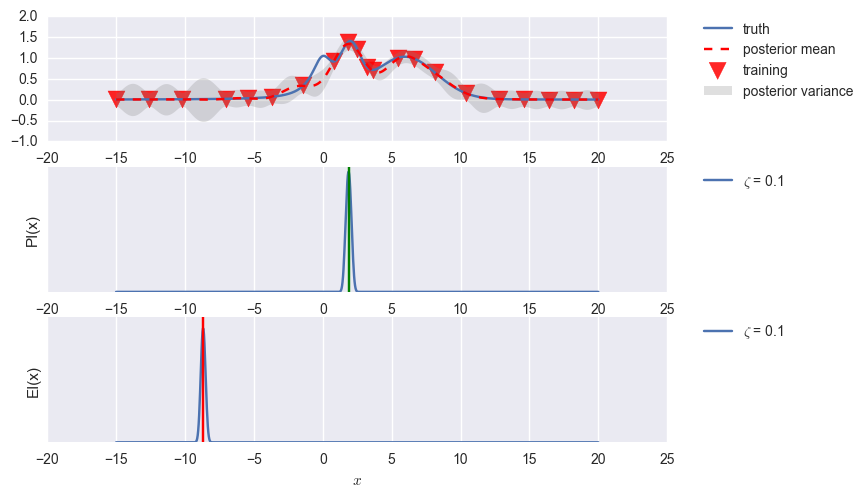


time step: 20
Number of line searches 24


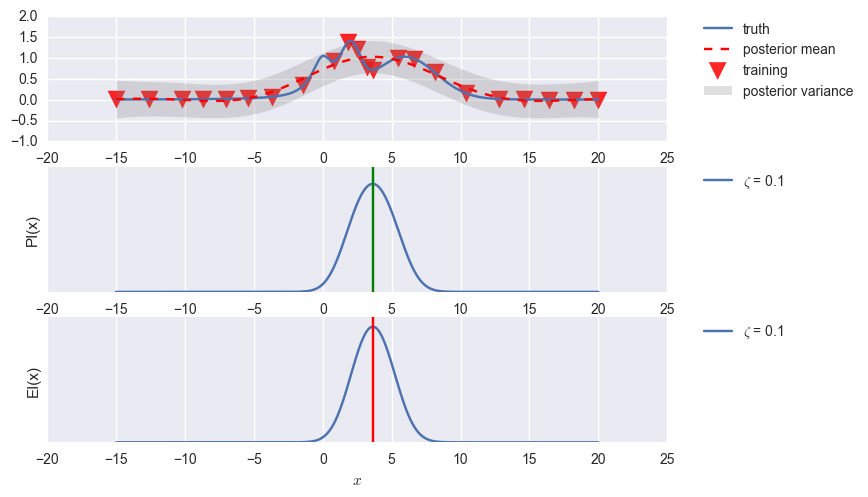


time step: 21
Number of line searches 18


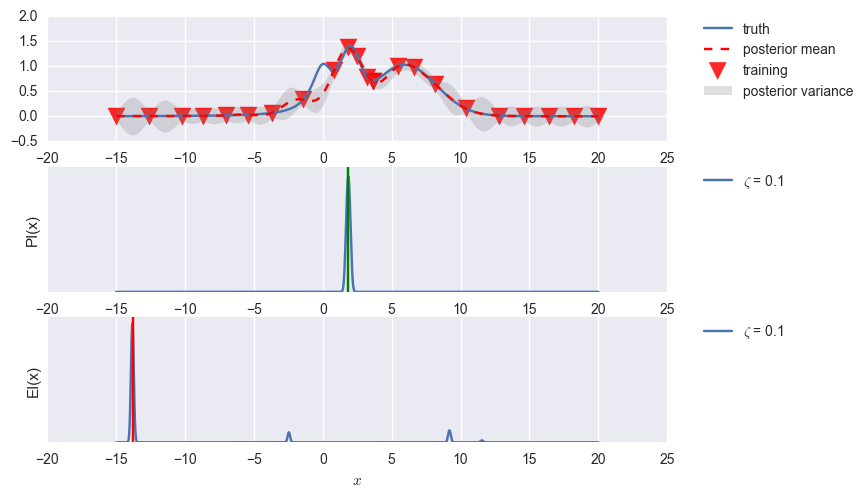


time step: 22
Number of line searches 22


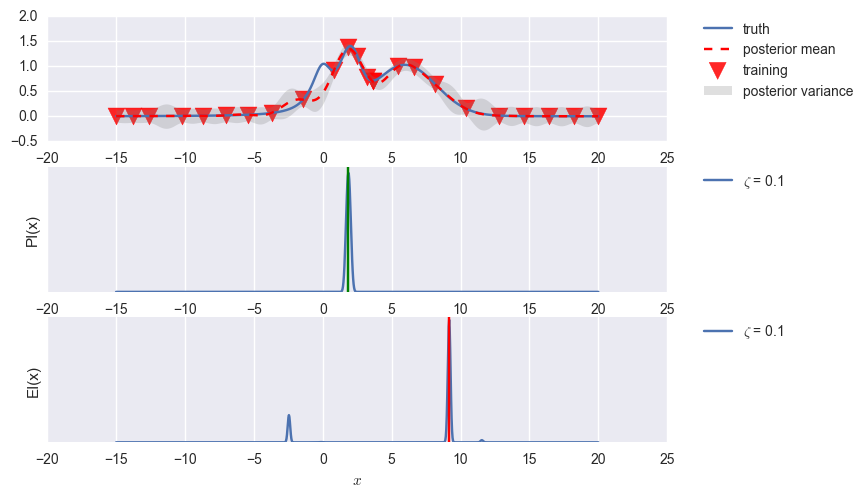


time step: 23
Number of line searches 26


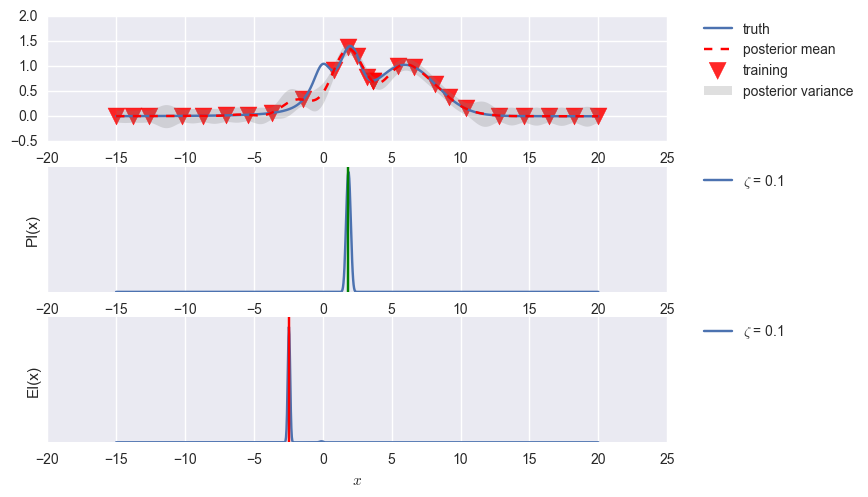


time step: 24
Number of line searches 35


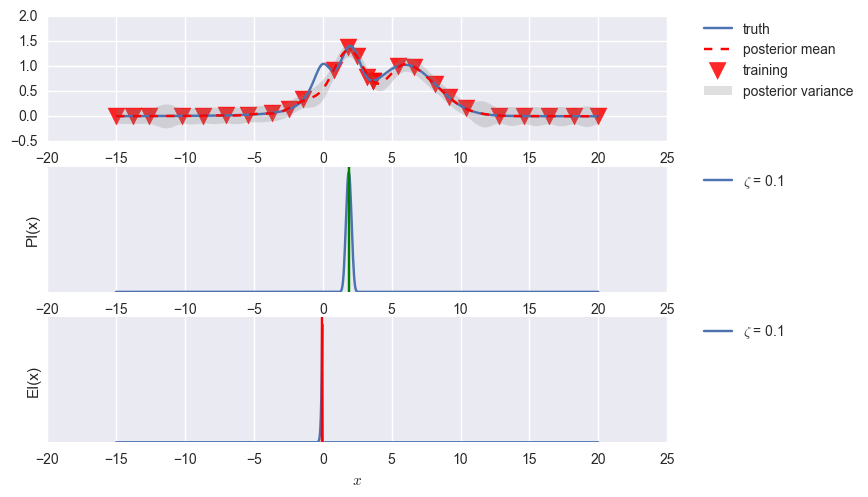


time step: 25
Number of line searches 20


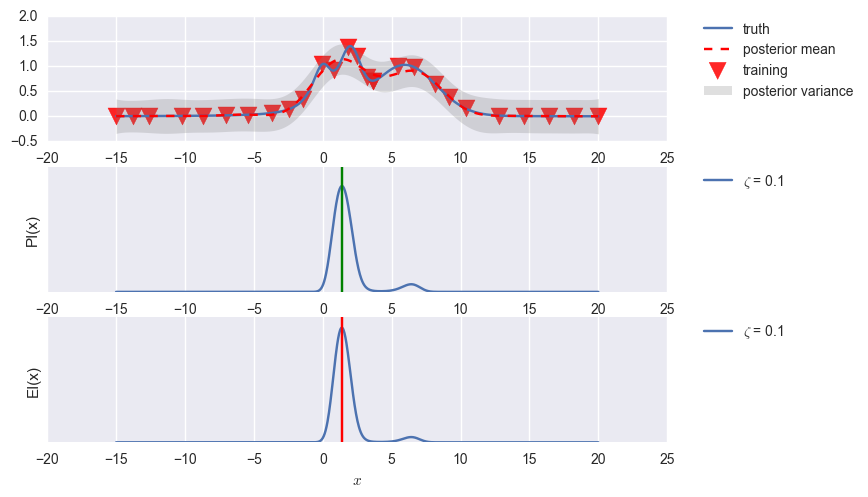

[-0.17250666613873267, 1.0430423234688977, 1.3673682319660478, 0.46693790738571339, 1.3154811009195606, 0.59427058940702548, 0.40247001310559871, 0.73092705925348622, 1.373476371370548, 1.3792676157970292, 1.363257043937437, 1.2250473556760104, 1.376719562686104, 0.37607174313271852, 1.3799903314760593, 1.3776607241535148, 0.67197802670484585, 1.3498421714800459, 1.3699379967140513, 0.67197802670484585, 1.377779242749521, 1.0061376064830627, 1.24014988454348, 0.34297902527786928, 0.22923374812371611]


In [12]:
regrt = []
for i in np.arange(25):
        if i < 1:
            x_train = x_init
        print '\ntime step:', i+1
        x_train, regret = bayOpt(x_train, .1)
    
reg1 = []
print regret
for i in np.arange(len(regret)):
    i = i+1
    reg1.append(np.mean(regret[0:i]))




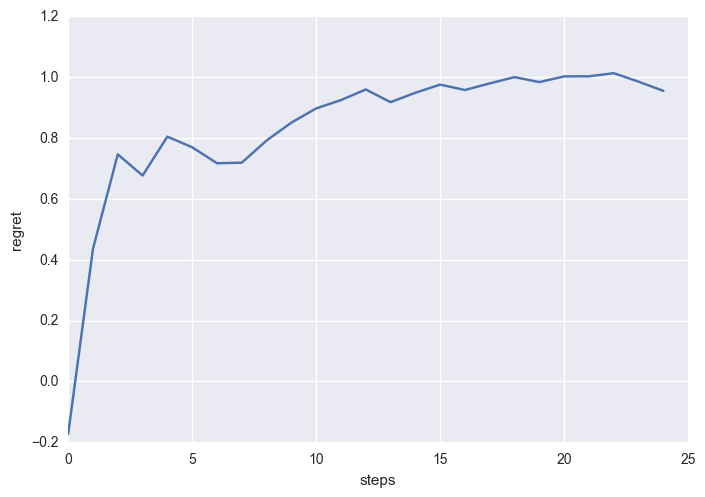

In [13]:
plt.plot(reg1)
plt.xlabel('steps')
plt.ylabel('regret')

### Summary

Bayesian Optimization provides a very powerful avenue to look at online learning problems. 


1. Real-Time Optimization of Marketing Spend - Very expensive to experiment with and not too many parameters to optimize over. Can we use a GP optimization process?

2. Finance: Portfolio optimization applications are just kicking up in literature. 
